# First Step in BNN-ABC-SS

The objective is to train a BBN using ABC-SS on some curved data

We are going to pick the sin because that is hard enough one but still manageable

In [1]:
# All the anoying imports
import numpy as np
import pylab as plt
import torch
import torch.nn as nn

In [7]:
bla = nn.Linear(1, 1)
blo = torch.Tensor([[1],[1]])
bla(blo)

tensor([[0.9872],
        [0.9872]], grad_fn=<AddmmBackward0>)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

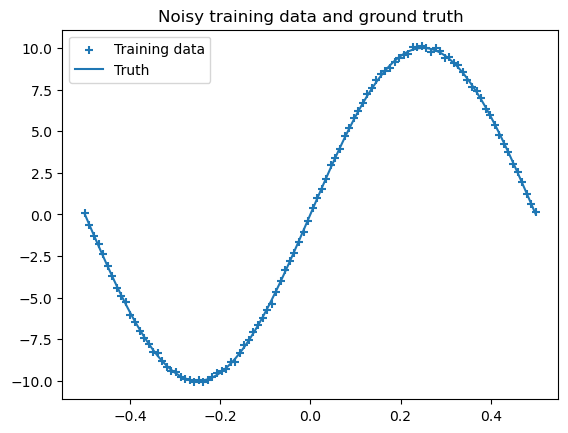

In [4]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10*np.sin(2*np.pi*x) + epsilon

# def f(x, sigma):
#     epsilon = np.random.randn(*x.shape) * sigma
#     return np.cos(x) + epsilon

train_size = 100
noise = 0.1

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
# X = np.linspace(-np.pi, np.pi, train_size).reshape(-1, 1)

y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend()


+ `X` here is a (100,1) array
+ `y` is the noised sin, same shape as before
+ `y_true` is the true value of y, 
same shape as before

NetWork architecture :

+ Input dimension : 1
+ Layer1 : 20
+ layer2 : 20
+ Output : 1

In [5]:
# Hyperparameters
n0 = 1
n1 = 20
n2 = 20
n3 = 1

In [6]:
def segment(theta, ns):

    total_len = np.sum([(ns[i]+1)*ns[i+1] for i in range(len(ns)-1)])
    if (total_len != len(theta)):
        print("Error : Wrong dimensions\n")
        return

    param_list = []
    index = 0
    for i in range(len(ns)-1):

        W = torch.Tensor(
            theta[index: (index + ns[i]*ns[i + 1])]).reshape(ns[i+1], ns[i])
        index += ns[i]*ns[i + 1]

        b = torch.Tensor(theta[index: (index + ns[i+1])]).reshape(ns[i+1])
        index += ns[i + 1]

        param_list.append(W)
        param_list.append(b)

    return param_list


In [7]:
def wrap(param_list):
    listLen = len(param_list)

    theta = param_list[0].reshape(np.prod(param_list[0].size()), 1)

    for i in range(1, listLen):
        theta = torch.concat(
            (theta, param_list[i].reshape(np.prod(param_list[i].size()), 1)))

    return theta


In [8]:
class FNN(nn.Module):
    def __init__(self, ns, theta=None):
        super(FNN, self).__init__()
        self.funclist = []
        self.nbLayers = len(ns)
        self.ns = ns
        for i in range(self.nbLayers-1):
            self.funclist.append(nn.Linear(ns[i], ns[i+1]))
        if (theta != None):
            self.update_weights(theta)

    def forward(self, x):
        for i in range(self.nbLayers - 2):
            x = self.funclist[i](x)
            x = torch.tanh(x)
        x = self.funclist[self.nbLayers - 2](x)
        return x

    def update_weights(self, thetas):
        param_list = segment(thetas, self.ns)
        nbparam = len(param_list)
        with torch.no_grad():
            for i in range(self.nbLayers - 1):
                self.funclist[i].weight = nn.Parameter(param_list[i*2])
                self.funclist[i].bias = nn.Parameter(param_list[i*2 + 1])

    def getTheta(self):
        param_list = []
        for i in range(self.nbLayers - 1):
            param_list.append(self.funclist[i].weight)
            param_list.append(self.funclist[i].bias)

        return wrap(param_list)


+ `X` here is a (100,1) tensor
+ `y` is the noised sin, same shape as before
+ `y_true` is the true value of y, 
same shape as before

In [9]:
XT = torch.Tensor(X).reshape(X.shape)
y = torch.Tensor(y).reshape(y.shape)
y_true = torch.Tensor(y_true).reshape(y_true.shape)


In [10]:
def BnnAbcSs(N, l, P0, epsilon, sigma_0, fact, ns):
    lll = np.sum([(ns[i]+1)*ns[i+1] for i in range(len(ns)-1)])

    thetas = torch.randn(lll, N)

    y_hats = torch.concat(
        tuple([FNN(ns, thetas[:, i]).forward(XT) for i in range(0, N)]), 1)

    rho_n = torch.cdist(y_hats.t(), y.t())

    sigma_j = sigma_0

    l_eps = []
    for j in range(0, l):
        rho_n, indices = torch.sort(rho_n, 0)
        thetas = thetas[:, indices.t()[0]]
        y_hats = y_hats[:, indices.t()[0]]

        epsilon_j = rho_n[int(N*P0)]
        sigma_j = sigma_j - 0.1

        # for debugging purposes
        l_eps.append(epsilon_j)

        new_thetas = []
        new_y_hats = []
        new_rho_n = []

        for k in range(0, int(N*P0)):
            mu = thetas[:, k].reshape(lll, 1)
            for i in range(0, int(1/P0)):
                new_theta = torch.normal(mu, sigma_j*fact).reshape(lll, 1)
                new_y_hat = FNN(ns, mu).forward(XT)
                rho = torch.cdist(new_y_hat.t(), y.t())

                if (rho <= epsilon_j):
                    # print("->yeah {}".format(k))
                    new_thetas.append(new_theta)
                    new_y_hats.append(new_y_hat)
                    new_rho_n.append(rho)
                    mu = new_theta

                else:
                    new_thetas.append(thetas[:, k].reshape(lll, 1))
                    new_y_hats.append(y_hats[:, k].reshape(y.shape))
                    new_rho_n.append(rho_n[k].reshape(1, 1))

        thetas = torch.concat(tuple(new_thetas), 1)
        y_hats = torch.concat(tuple(new_y_hats), 1)
        rho_n = torch.concat(tuple(new_rho_n), 0)

    return thetas, y_hats, rho_n

In [20]:
N = 10000
l = 4
P0 = 0.1
epsilon = 0.1
sigma_0 = (l+1)*0.1
fact = 1e-1
ns = [1,20,20,1]
thetas, y_hats, rho_n = BnnAbcSs(N, l, P0, epsilon, sigma_0, fact, ns)

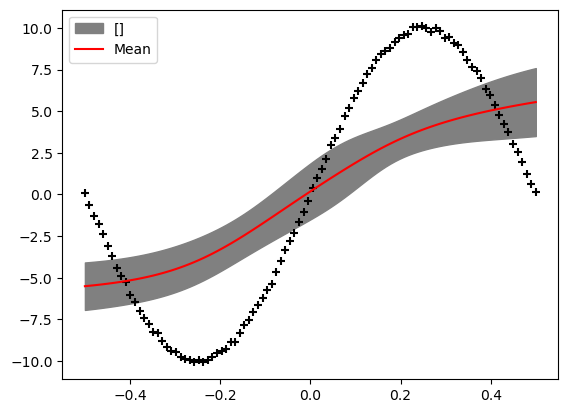

In [18]:
std = torch.sqrt(y_hats.var(1))
mean = y_hats.mean(1)

binf = (mean - 3*std).reshape(y.shape).detach().numpy()
bsup = (mean + 3*std).reshape(y.shape).detach().numpy()

plt.fill_between(XT.ravel(), binf[:,0], bsup[:,0], color = 'gray', label = "[]")
plt.plot(XT, (mean).reshape(y.shape).detach().numpy(), label = "Mean", color = "r")
plt.scatter(XT, y, marker='+', color = 'k')
plt.legend()


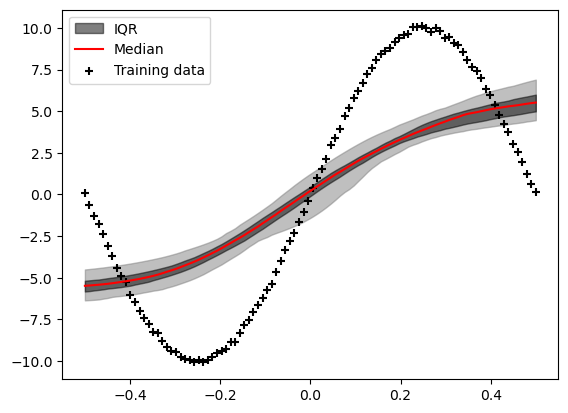

In [19]:
q2_5 = y_hats.quantile(0.025, 1).reshape(y.shape).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(y.shape).detach().numpy()
q25 =  y_hats.quantile(0.25, 1).reshape(y.shape).detach().numpy()
q75 =  y_hats.quantile(0.75, 1).reshape(y.shape).detach().numpy()

plt.fill_between(XT.ravel(), q2_5[:,0], q97_5[:,0], alpha=0.5,color = 'gray')
plt.fill_between(XT.ravel(), q25[:,0], q75[:,0], alpha=0.5,color = 'k',label='IQR')
plt.plot(XT, y_hats.quantile(0.5, 1).reshape(y.shape).detach().numpy(), label ="Median", color = 'r')

plt.scatter(XT, y, marker='+', color = 'k', label='Training data')
plt.legend()

Things that i "discovered" dealing with this shit :
+ It's slow (like "i have to wait for the results" slow)
+ Evaluation of the linear transformations through the Network is taking a shit-ton of time
+ The results of the algorithm are highly depend on the hyperparameters given
  + For instance, the complexity of the network i.e. `ns`
  + The number of samples of `theta`, `N`
  + The number of iteration
  + <span style = "color:red"> The step `fact` </span>
+ The grey band should at least cover all of the points without leaving anything outside
+ The <span style = "color:red">  median </span> line should go at least close to the "middle" of the points

Basically, we need an actual mathematically "sound" way to get a consistant and good confidence tube.
Which means a way for us to wrap that bitch up, using hyperparameters that are automaticaly calculated with respect to statistical propeties of the data gives.